I. KẾT NỐI VỚI CƠ SƠR DỮ LIỆU TỪ SQL ĐÃ KẾT NỐI VỚI CLOUD:

In [ ]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import dash
from dash import dcc, html
import dash_bootstrap_components as dbc
import folium
from dash.dependencies import Input, Output
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time

# connect to Azure
server = 'zillow-crawl-data.database.windows.net'
database = 'Zillow_data'
username = 'zillow'
password = ''
driver = '{ODBC Driver 17 for SQL Server}'

conn = pyodbc.connect(
    f'DRIVER={driver};SERVER={server};PORT=1433;DATABASE={database};UID={username};PWD={password}'
)


II. THỰC HIỆN LẦN LƯỢT TỪNG BIỂU ĐỒ PHÂN TÍCH

1. Biểu đồ tròn thể hiện tỉ trọng của các loại nhà trong bộ dữ liệu

In [ ]:

query1 = """
SELECT ht.House_type, COUNT(p.House_ID) AS Count
FROM Properties_table p
JOIN House_Type_table ht ON p.House_Type_ID = ht.House_Type_ID
GROUP BY ht.House_type
"""
df1 = pd.read_sql(query1, conn)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24932\1390126487.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1 = pd.read_sql(query1, conn)


In [3]:
df1.head(6)

House_type  Count
0     Entry-level House   1601
1          Luxury House   1398
2        Mid-tier House   6203
3    Super-Luxury House     34
4    Ultra-Luxury House    123
5  Upper Mid-tier House   3788

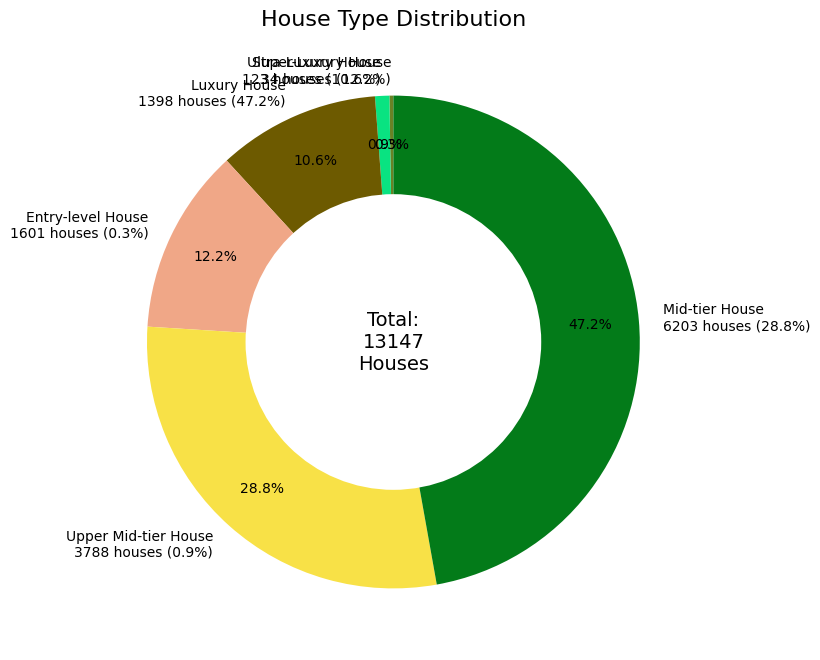

In [ ]:
#1 donuu chart
house_counts = df1.set_index('House_type')['Count']
house_percents = house_counts / house_counts.sum() * 100

house_colors = {
    'Mid-tier House': '#037B19',       
    'Upper Mid-tier House': '#F8E147', 
    'Entry-level House': '#F0A787',    
    'Luxury House': '#6D5A00',         
    'Ultra-Luxury House': '#09E381',   
    'Super-Luxury House': '#698225'   
}

house_counts = house_counts.sort_values()

def plot_donut(house_counts, house_colors):
    labels = [
        f"{house_type}\n{count} houses ({percent:.1f}%)"
        for house_type, count, percent in zip(
            house_counts.index, house_counts.values, house_percents
        )
    ]
    sizes = house_counts.values
    colors = [house_colors.get(house_type, '#FFFFFF') for house_type in house_counts.index]
    
    fig, ax = plt.subplots(figsize=(8, 8)) 
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        pctdistance=0.8, 
        textprops={'fontsize': 10}  
    )
    ax.set(aspect="equal") 


    centre_circle = plt.Circle((0, 0), 0.60, fc='white') 
    fig.gca().add_artist(centre_circle)

    total = house_counts.sum()
    ax.text(0, 0, f"Total:\n{total}\nHouses", ha='center', va='center', fontsize=14)

    plt.title('House Type Distribution', fontsize=16)
    plt.show()

plot_donut(house_counts, house_colors)


2. Biểu đồ thể hiện phân phối giá nhà trung bình và diện tích trung bình

In [ ]:
query2 = "SELECT Price FROM Properties_table"
df2 = pd.read_sql(query2, conn)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24932\1564380754.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(query2, conn)


In [6]:
df2.head()

Price
0   275000.0
1  1850000.0
2  2199000.0
3   279000.0
4   299000.0

In [ ]:
#gauge chart
average_price = df2['Price'].mean()

fig = go.Figure(go.Indicator(
    mode="gauge+number",
    value=average_price,
    title={'text': "Average House Price"},
    gauge={
        'shape': 'angular',
        'axis': {'range': [0, average_price]},  
        'bar': {'color': '#037B19'}, 
        'steps': [
            {'range': [0, average_price], 'color': '#037B19'} 
        ]
    },
    number={'font': {'size': 20, 'color': 'red'}, 'suffix': ' USD'}
))
fig.update_layout(
    height=300, 
    width=450  
)
fig.show()


In [ ]:
query3 = "SELECT [Sqft] FROM Properties_table"
df3 = pd.read_sql(query3, conn)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24932\1290827128.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [ ]:
average_sqft = df3['Sqft'].mean()

fig = go.Figure(go.Indicator(
    mode="gauge+number",
    value= average_sqft,
    title={'text': "Average House Square_Footage"},
    gauge={
        'shape': 'angular',
        'axis': {'range': [0, average_sqft]}, 
        'bar': {'color': '#037B19'}, 
        'steps': [
            {'range': [0, average_sqft], 'color': '#037B19'}  
        ]
    },
    number={'font': {'size': 20, 'color': 'red'}, 'suffix': ''}
))
fig.update_layout(
    height=300,  
    width=450   
)

fig.show()


3. Biều đồ phễu thể hiện Top 5 thành phố có mức giá trung bình cao nhất

In [ ]:
query4 = """
SELECT c.City, p.Price
FROM Properties_table AS p
JOIN City_table AS c ON p.City_ID = c.City_ID
"""
df4 = pd.read_sql(query4, conn)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24932\220484896.py:7: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [11]:
df4.head()

City      Price
0    Des Moines   275000.0
1   Minneapolis  1850000.0
2       Lincoln  2199000.0
3  Philadelphia   279000.0
4  Philadelphia   299000.0

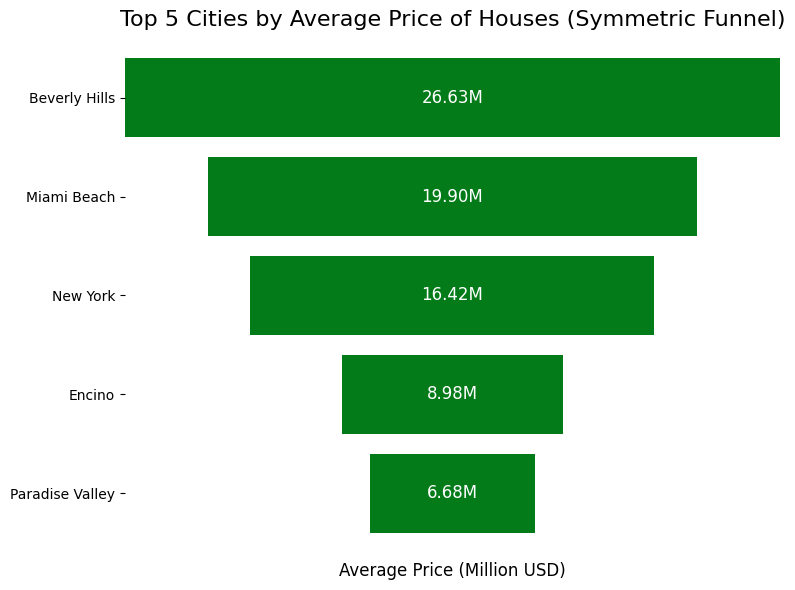

In [ ]:
#funnel chart
city_avg_price = df4.groupby('City')['Price'].mean().reset_index()

top5_cities = city_avg_price.sort_values(by='Price', ascending=False).head(5)

cities = top5_cities['City'] 
avg_prices = top5_cities['Price'] / 1e6 

fig, ax = plt.subplots(figsize=(8, 6))

max_width = max(avg_prices) 
for i, (city, price) in enumerate(zip(cities, avg_prices)):
    left = (max_width - price) / 2 
    ax.barh(city, price, left=left, color='#037B19', height=0.8)

    ax.text(max_width / 2, i, f'{price:.2f}M', va='center', ha='center',
            fontsize=12, color='white')

ax.set_title('Top 5 Cities by Average Price of Houses (Symmetric Funnel)', fontsize=16)
ax.set_xlabel('Average Price (Million USD)', fontsize=12)
ax.set_xlim(0, max_width)
ax.set_xticks([])
ax.invert_yaxis() 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.show()

4. Biểu đồ thể hiện mối liên hệ giữa số phòng ngủ với giá và diện tích trung bình

In [ ]:
query5 = """
SELECT 
    pd.Bedroom,
    p.Price,
    p.Sqft
FROM 
    Properties_table AS p
JOIN 
    Properties_Details_table AS pd ON p.House_ID = pd.House_ID
WHERE 
    pd.Bedroom < 10
"""
df5 = pd.read_sql(query5, conn)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24932\563969483.py:14: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [14]:
df5.head()

Bedroom      Price    Sqft
0        3   275000.0  1364.0
1        2  1850000.0  3079.0
2        7  2199000.0  7086.0
3        2   279000.0   905.0
4        3   299000.0  1330.0

In [ ]:
#line chart
avg_data = df5.groupby('Bedroom').agg({
    'Price': 'mean',
    'Sqft': 'mean'
}).reset_index()

bedrooms = avg_data['Bedroom']
avg_price = avg_data['Price']
avg_area = avg_data['Sqft']

fig, ax1 = plt.subplots(figsize=(10, 6))

color_area = '#037B19'
ax1.set_xlabel('Number of Bedrooms', fontsize=12)
ax1.set_ylabel('Average Square Footage (sqft)', color=color_area, fontsize=12)
line1 = ax1.plot(
    bedrooms, avg_area, color=color_area, marker='o', label='Average Square Footage'
)
ax1.tick_params(axis='y', labelcolor=color_area)
ax1.set_ylim(0, max(avg_area) * 1.2) 
ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

ax2 = ax1.twinx()
color_price = 'blue'
ax2.set_ylabel('Average Price (USD)', color=color_price, fontsize=12)
line2 = ax2.plot(
    bedrooms, avg_price, color=color_price, marker='s', linestyle='--', label='Average Price'
)
ax2.tick_params(axis='y', labelcolor=color_price)
ax2.set_ylim(0, max(avg_price) * 1.2) 

lines = line1 + line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

plt.title('Average Price and Square Footage by Number of Bedrooms', fontsize=16)
plt.tight_layout()

plt.show()

In [ ]:
query6 = """
SELECT 
    c.City, 
    ht.House_Type, 
    COUNT(*) AS House_Count
FROM 
    Properties_table AS p
JOIN 
    City_table AS c ON p.City_id = c.City_id
JOIN 
    House_Type_table AS ht ON p.House_Type_id = ht.House_Type_id
GROUP BY 
    c.City, ht.House_Type
ORDER BY 
    c.City, House_Count DESC;
"""

df6 = pd.read_sql(query6, conn)
print(df6.head())

       City            House_Type  House_Count
0  Aberdeen     Entry-level House            1
1   Abilene        Mid-tier House           80
2   Abilene     Entry-level House           40
3   Abilene  Upper Mid-tier House           16
4   Abilene          Luxury House            1


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24932\3961869004.py:20: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



6. Biểu đồ cột chồng thể hiện phân phối của các loại nhà trong mỗi thành phố

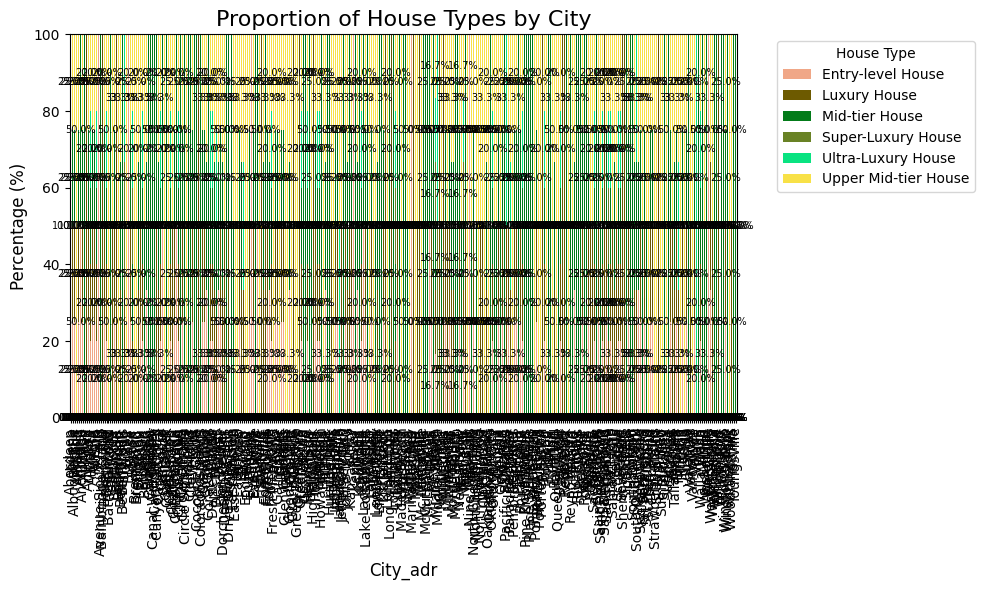

In [ ]:
#bar stacked chart
house_counts = df6.groupby(['City', 'House_Type']).size().reset_index(name='House_Count')

city_totals = house_counts.groupby('City')['House_Count'].transform('sum') 
house_counts['Percentage'] = (house_counts['House_Count'] / city_totals) * 100

pivot_data = house_counts.pivot(index='City', columns='House_Type', values='Percentage').fillna(0)

fig, ax = plt.subplots(figsize=(10, 6))
colors = {
    'Mid-tier House': '#037B19',    
    'Upper Mid-tier House': '#F8E147',        
    'Entry-level House': '#F0A787',  
    'Luxury House': '#6D5A00',       
    'Ultra-Luxury House': '#09E381',  
    'Super-Luxury House': '#698225'   
}

pivot_data.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_data.columns], ax=ax)

ax.set_title('Proportion of House Types by City', fontsize=16)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_xlabel('City_adr', fontsize=12)
ax.legend(title='House Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.set_ylim(0, 100) 

for bar in ax.containers:
    ax.bar_label(bar, fmt='%.1f%%', label_type='center', fontsize=7)

plt.tight_layout()
plt.show()


7. Biểu đồ bàn đồ thể hiện vị trí phân bố của các ngôi nhà trong bộ dữ liệu

In [ ]:
query7 = """
SELECT 
    p.Street_adr,
    c.City,
    s.State_name,
    p.Price,
    p.Sqft
FROM 
    Properties_table AS p
JOIN 
    City_table AS c ON p.City_id = c.City_id
JOIN 
    State_table AS s ON c.State_id = s.State_id

"""
df7 = pd.read_sql(query7, conn)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24932\2367690578.py:17: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [ ]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13147 entries, 0 to 13146
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Street_adr  13147 non-null  object 
 1   City        13147 non-null  object 
 2   State_name  13147 non-null  object 
 3   Price       13147 non-null  float64
 4   Sqft        13147 non-null  float64
dtypes: float64(2), object(3)
memory usage: 513.7+ KB


In [ ]:
df7 = df7.head(100)
df7['Full_Address'] = df7['Street_adr'] + ', ' + df7['City'] + ', ' + df7['State_name']
geolocator = Nominatim(user_agent="geoapi")

def get_coordinates(address, index):
    try:
        print(f"Đang quét dòng {index}")
        location = geolocator.geocode(address, timeout=5)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except GeocoderTimedOut:
        print(f"Lỗi timeout tại dòng {index}, thử lại sau.") 
        return None, None

latitude_list = []
longitude_list = []

for index, row in df7.iterrows():
    lat, lon = get_coordinates(row['Full_Address'], index)
    latitude_list.append(lat)
    longitude_list.append(lon)
    time.sleep(3) 
    
df7['Latitude'] = latitude_list
df7['Longitude'] = longitude_list

df = df7.dropna(subset=['Latitude', 'Longitude'])

map_center = [df7['Latitude'].mean(), df7['Longitude'].mean()] 
folium_map = folium.Map(location=map_center, zoom_start=10)

for index, row in df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=(
            f"Address: {row['Full_Address']}<br>"
            f"Price: {row['Price']}$<br>"
            f"Square Footage: {row['Sqft']} sqft"
        ),
        tooltip="Click for details"
    ).add_to(folium_map)

folium_map.save("map.html")

folium_map

Đang quét dòng 0
Đang quét dòng 1
Đang quét dòng 2
Đang quét dòng 3
Đang quét dòng 4
Đang quét dòng 5
Đang quét dòng 6
Đang quét dòng 7
Đang quét dòng 8
Đang quét dòng 9
Đang quét dòng 10
Đang quét dòng 11
Đang quét dòng 12
Đang quét dòng 13
Đang quét dòng 14
Đang quét dòng 15
Đang quét dòng 16
Đang quét dòng 17
Đang quét dòng 18
Đang quét dòng 19
Đang quét dòng 20
Đang quét dòng 21
Đang quét dòng 22
Đang quét dòng 23
Đang quét dòng 24
Đang quét dòng 25
Đang quét dòng 26
Đang quét dòng 27
Đang quét dòng 28
Đang quét dòng 29
Đang quét dòng 30
Đang quét dòng 31
Đang quét dòng 32
Đang quét dòng 33
Đang quét dòng 34
Đang quét dòng 35
Đang quét dòng 36
Đang quét dòng 37
Đang quét dòng 38
Đang quét dòng 39
Đang quét dòng 40
Đang quét dòng 41
Đang quét dòng 42
Đang quét dòng 43
Đang quét dòng 44
Đang quét dòng 45
Đang quét dòng 46
Đang quét dòng 47
Đang quét dòng 48
Đang quét dòng 49
Đang quét dòng 50
Đang quét dòng 51
Đang quét dòng 52
Đang quét dòng 53
Đang quét dòng 54
Đang quét dòng 55
Đa

III. DASHBOARD TRỰC QUAN HOÁ QUAN HỆ GIỮA CÁC BIỂU ĐỒ VÀ BỘ DỮ LIỆU

Liên kết tất cả các bẳng có trong co sở dữ liệu:

In [21]:
query = """
SELECT 
    p.House_ID, 
    p.Price, 
    p.Sqft,
    p.Street_adr, 
    s.State_name, 
    c.City, 
    ht.House_Type, 
    ht.Min_Price, 
    ht.Max_Price, 
    pd.Bedroom, 
    pd.Bathroom
FROM 
    Properties_table p
JOIN 
    State_table s ON p.State_ID = s.State_ID
JOIN 
    City_table c ON p.City_ID = c.City_ID
JOIN 
    House_Type_table ht ON p.House_Type_ID = ht.House_Type_ID
LEFT JOIN 
    Properties_Details_table pd ON p.House_ID = pd.House_ID;
"""
df = pd.read_sql(query, conn)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24932\509603131.py:25: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [22]:
print(df.head())

    House_ID      Price    Sqft           Street_adr State_name          City  \
0  101539594   275000.0  1364.0   6812 Sweetwater Dr         IA    Des Moines   
1  101656471  1850000.0  3079.0  201 11th St S #2600         MN   Minneapolis   
2  101693495  2199000.0  7086.0      2255 SW 47th St         NE       Lincoln   
3   10171333   279000.0   905.0         104 Sigel St         PA  Philadelphia   
4   10171365   299000.0  1330.0         212 Sigel St         PA  Philadelphia   

       House_Type  Min_Price  Max_Price  Bedroom  Bathroom  
0  Mid-tier House   200000.0   499999.0        3         3  
1    Luxury House  1000000.0  4999999.0        2         3  
2    Luxury House  1000000.0  4999999.0        7         6  
3  Mid-tier House   200000.0   499999.0        2         1  
4  Mid-tier House   200000.0   499999.0        3         2  


In [ ]:
# Dashboard
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = html.Div([
    dbc.Row([
        dbc.Col([
            html.H3('Lọc theo Bang'),
            dcc.Dropdown(
                id='state-filter',
                options=[{'label': 'All', 'value': 'All'}] + [{'label': state, 'value': state} for state in df['State_name'].unique()],
                multi=True, 
                value=['All'], 
                style={'width': '100%'}
            ),
        ], width=3),
        dbc.Col([
            html.H3('Lọc theo Thành Phố'),
            dcc.Dropdown(
                id='city-filter',
                options=[{'label': 'All', 'value': 'All'}],
                multi=True,  
                value=['All'],  
                style={'width': '100%'}
            ),
        ], width=3),

        dbc.Col([
            html.H3('Price'),
            dbc.Row([
                dbc.Col(dcc.Input(
                    id='min-price-input',
                    type='number',
                    value=df['Price'].min(),  
                    style={'width': '100%'}
                ), width=2),
                dbc.Col(dcc.Input(
                    id='max-price-input',
                    type='number',
                    value=df['Price'].max(),  
                    style={'width': '100%'}
                ), width=2),
                dbc.Col(dcc.RangeSlider(
                    id='price-filter',
                    min=df['Price'].min(),
                    max=df['Price'].max(),
                    step=50000,
                    marks={i: f'${i/1000}K' for i in range(int(df['Price'].min()), int(df['Price'].max()), 500000)},
                    value=[df['Price'].min(), df['Price'].max()]
                ), width=8)
            ])
        ], width=6)
    ]),
    dbc.Row([
        dbc.Col([
            # Chart 1: Price Gauge
            dbc.Row(html.Div(id='price-gauge')),
            # Chart 2: Sqft Gauge
            dbc.Row(html.Div(id='sqft-gauge'))
        ], width=4), 

        dbc.Col([
            dbc.Row(html.Div(id='stacked-bar-chart')),
            dbc.Row(html.Div(id='house-type-donut-chart'))], width=4),
        dbc.Col([
            # Chart 1: Price Gauge
            dbc.Row(html.Div(id='funnel-chart')),
            #Chart 2: Sqft Gauge
            dbc.Row(html.Div(id='line-chart'))
        ], width=4), 
    ]),
    dbc.Row([
        dbc.Col(dbc.Col(html.Div(id='map-view', children=[
            html.H3('Interactive Map'),
            html.Iframe(
                id='map',
                srcDoc=open(r"C:\Users\LENOVO\Downloads\map.html", 'r').read(),
                width='150%',
                height='500px',
                style={'border': 'none'}
            )
        ]), width=8))   
    ])
])
@app.callback(
    [Output('min-price-input', 'value'),
     Output('max-price-input', 'value')],
    [Input('state-filter', 'value'),
     Input('city-filter', 'value')]
)
def update_price_inputs(selected_states, selected_cities):
    filtered_df = df.copy()
    if selected_states and 'All' not in selected_states:
        filtered_df = filtered_df[filtered_df['State_name'].isin(selected_states)]

    if selected_cities and 'All' not in selected_cities:
        filtered_df = filtered_df[filtered_df['City'].isin(selected_cities)]
   
    min_price = filtered_df['Price'].min()
    max_price = filtered_df['Price'].max()
    return min_price, max_price
@app.callback(
    dash.dependencies.Output('city-filter', 'options'),
    [dash.dependencies.Input('state-filter', 'value')]
)
def update_city_options(state):
    if 'All' in state:
        cities = df['City'].unique().tolist()
    else:
        cities = df[df['State_name'].isin(state)]['City'].unique().tolist()
    return [{'label': 'All', 'value': 'All'}] + [{'label': city, 'value': city} for city in cities]

#Donut Chart
@app.callback(
    dash.dependencies.Output('house-type-donut-chart', 'children'),
    [dash.dependencies.Input('state-filter', 'value'),
     dash.dependencies.Input('city-filter', 'value'),
     dash.dependencies.Input('price-filter', 'value')]
)
def update_house_type_donut(state, city, price_range):
    #filter
    if 'All' in state:
        state = df['State_name'].unique().tolist()
    if 'All' in city:
        city = df['City'].unique().tolist()

    filtered_df = df[(df['State_name'].isin(state)) & 
                     (df['City'].isin(city)) & 
                     (df['Price'] >= price_range[0]) & 
                     (df['Price'] <= price_range[1])]
   
    house_counts = filtered_df['House_Type'].value_counts()
    house_percents = house_counts / house_counts.sum() * 100

    house_colors = {
        'Mid-tier House': '#037B19',       
        'Upper Mid-tier House': '#F8E147',
        'Entry-level House': '#F0A787',   
        'Luxury House': '#6D5A00',         
        'Ultra-Luxury House': '#09E381',   
        'Super-Luxury House': '#698225'    
    }

    house_counts = house_counts.sort_values()
    labels = [
        f"{house_type}"
        for house_type, count, percent in zip(
            house_counts.index, house_counts.values, house_percents
        )
    ]
    sizes = house_counts.values
    colors = [house_colors.get(house_type, '#FFFFFF') for house_type in house_counts.index]

    fig = go.Figure(data=[go.Pie(
        labels=labels,
        values=sizes,
        hoverinfo="label+percent",
        marker=dict(colors=colors),
        hole=0.5, 
        textinfo='percent',     )])

    total_houses = house_counts.sum()
    fig.add_annotation(
        text=f"{total_houses}",
        x=0.5,
        y=0.5,
        font_size=16,
        showarrow=False,
        font=dict(color='black')
    )

    fig.update_layout(
        title='House Type Distribution',
        showlegend=True,
        height=500
    )

    return dcc.Graph(figure=fig)

#gauge price chart
@app.callback(
    dash.dependencies.Output('price-gauge', 'children'),
    [dash.dependencies.Input('state-filter', 'value'),
     dash.dependencies.Input('city-filter', 'value'),
     dash.dependencies.Input('price-filter', 'value')]
)
def update_house_type_donut(state, city, price_range):
    if 'All' in state:
        state = df['State_name'].unique().tolist()
    if 'All' in city:
        city = df['City'].unique().tolist()


    filtered_df = df[(df['State_name'].isin(state)) &
                     (df['City'].isin(city)) &
                     (df['Price'] >= price_range[0]) &
                     (df['Price'] <= price_range[1])]
   
    average_price = filtered_df['Price'].mean()
   
    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=average_price,
        title={'text': "Average House Price", 'font': {'size': 12}},
        gauge={'shape': 'angular', 'axis': {'range': [0, average_price]}, 'bar': {'color': '#037B19'}}
    ))
    return dcc.Graph(figure=fig)

@app.callback(
    dash.dependencies.Output('sqft-gauge', 'children'),
    [dash.dependencies.Input('state-filter', 'value'),
     dash.dependencies.Input('city-filter', 'value'),
     dash.dependencies.Input('price-filter', 'value')]
)
def update_house_type_donut(state, city, price_range):
    if 'All' in state:
        state = df['State_name'].unique().tolist()
    if 'All' in city:
        city = df['City'].unique().tolist()


    filtered_df = df[(df['State_name'].isin(state)) &
                     (df['City'].isin(city)) &
                     (df['Price'] >= price_range[0]) &
                     (df['Price'] <= price_range[1])]
   
    average_sqft = filtered_df['Sqft'].mean()
   
    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=average_sqft,
        title={'text': "Average House Square Footage", 'font': {'size': 12}},
        gauge={'shape': 'angular', 'axis': {'range': [0, average_sqft]}, 'bar': {'color': '#037B19'}}
    ))
    return dcc.Graph(figure=fig)

#funnel chart
@app.callback(
    dash.dependencies.Output('funnel-chart', 'children'),
    [dash.dependencies.Input('state-filter', 'value'),
     dash.dependencies.Input('city-filter', 'value'),
     dash.dependencies.Input('price-filter', 'value')]
)
def update_house_type_donut(state, city, price_range):
    # filter
    if 'All' in state:
        state = df['State_name'].unique().tolist()
    if 'All' in city:
        city = df['City'].unique().tolist()

    filtered_df = df[(df['State_name'].isin(state)) & 
                     (df['City'].isin(city)) & 
                     (df['Price'] >= price_range[0]) & 
                     (df['Price'] <= price_range[1])]
    city_avg_price = filtered_df.groupby('City')['Price'].mean().reset_index()

    top5_cities = city_avg_price.sort_values(by='Price', ascending=False).head(5)

    fig = go.Figure(go.Funnel(
        y=top5_cities['City'],
        x=top5_cities['Price'],
        text="",
        hoverinfo="text+x",
        marker=dict(color='#037B19') 
    ))

    fig.update_layout(
        title="Top 5 City by Price",
        title_font=dict(size=12) 
    )

    return dcc.Graph(figure=fig)
#map
@app.callback(
    dash.dependencies.Output('map', 'srcDoc'),
    [dash.dependencies.Input('state-filter', 'value'),
     dash.dependencies.Input('city-filter', 'value'),
     dash.dependencies.Input('price-filter', 'value')]
)
def update_house_type_donut(state, city, price_range):
    if 'All' in state:
        state = df['State_name'].unique().tolist()
    if 'All' in city:
        city = df['City'].unique().tolist()


    filtered_df = df[(df['State_name'].isin(state)) &
                     (df['City'].isin(city)) &
                     (df['Price'] >= price_range[0]) &
                     (df['Price'] <= price_range[1])]
   
    new_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)
    for _, row in filtered_df.iterrows():
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=f"<b>Price:</b> ${row['Price']}, <b>Bedroom:</b> {row['Bedroom']}, <b>Bathroom:</b> {row['Bathroom']}, <b>Sqft:</b> {row['Sqft']}",
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(new_map)

    map_path = 'assets/map.html'
    new_map.save(map_path)
    return new_map
# Bar Stacked Chart
house_type_colors = {
    'Mid-tier House': '#037B19',
    'Upper Mid-tier House': '#F8E147',
    'Entry-level House': '#F0A787',
    'Luxury House': '#6D5A00',
    'Ultra-Luxury House': '#09E381',
    'Super-Luxury House': '#698225'
}

@app.callback(
    dash.dependencies.Output('stacked-bar-chart', 'children'),
    [dash.dependencies.Input('state-filter', 'value'),
     dash.dependencies.Input('city-filter', 'value'),
     dash.dependencies.Input('price-filter', 'value')]
)
def update_stacked_bar_chart(state, city, price_range):
    # filter
    if 'All' in state:
        state = df['State_name'].unique().tolist()
    if 'All' in city:
        city = df['City'].unique().tolist()

    filtered_df = df[(df['State_name'].isin(state)) & 
                     (df['City'].isin(city)) & 
                     (df['Price'] >= price_range[0]) & 
                     (df['Price'] <= price_range[1])]

    house_counts = filtered_df.groupby(['City', 'House_Type'])['House_ID'].count().unstack().fillna(0)

    fig = go.Figure(data=[
        go.Bar(
            name=house_type, 
            x=house_counts.index, 
            y=house_counts[house_type],
            marker_color=house_type_colors.get(house_type, '#000000') 
        ) 
        for house_type in house_counts.columns
    ])

    fig.update_layout(
        title="House Type Distribution by City",
        title_font=dict(size=12),  
        barmode='stack', 
        xaxis_title="City", 
        yaxis_title="Number of Houses",  
        showlegend=True
    )

    return dcc.Graph(figure=fig)
#line chart
@app.callback(
    dash.dependencies.Output('line-chart', 'children'),
    [dash.dependencies.Input('state-filter', 'value'),
     dash.dependencies.Input('price-filter', 'value')]
)
def update_line_chart(state, price_range):
    #filter
    if 'All' in state:
        state = df['State_name'].unique().tolist()

    filtered_df = df[(df['State_name'].isin(state)) &
                     (df['Price'] >= price_range[0]) &
                     (df['Price'] <= price_range[1])]

    if filtered_df.empty:
        return html.Div("No data available for the selected filters.")

    bedroom_avg_price = filtered_df.groupby('Bedroom')['Price'].mean().reset_index()
    bedroom_avg_sqft = filtered_df.groupby('Bedroom')['Sqft'].mean().reset_index()

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=bedroom_avg_price['Bedroom'],
        y=bedroom_avg_price['Price'],
        mode='lines',
        name="Avg Price",
        line=dict(color='blue'),
        yaxis='y2'  
    ))

    fig.add_trace(go.Scatter(
        x=bedroom_avg_sqft['Bedroom'],
        y=bedroom_avg_sqft['Sqft'],
        mode='lines',
        name="Avg Sqft",
        line=dict(color='#037B19'),
        yaxis='y1'
    ))

    fig.update_layout(
        title="Average Price and Square Footage by Bedrooms",
        title_font=dict(size=12),
        xaxis_title="Bedrooms",
        yaxis_title="Average Square Footage",
        yaxis=dict(
            title="Average Square Footage (Sqft)",
            side="left",
            tickmode="array",
            tickvals=[i * 2000 for i in range(int(filtered_df['Sqft'].min() // 2000), int(filtered_df['Sqft'].max() // 2000) + 1)],
            ticktext=[f"{i}K" for i in range(int(filtered_df['Sqft'].min() // 2000), int(filtered_df['Sqft'].max() // 2000) + 1)],
            showgrid=True,
            gridcolor="#d3d3d3"
        ),
        yaxis2=dict(
            title="Average Price (USD)",
            overlaying="y",
            side="right",
            tickmode="array",
            tickvals=[i * 5000000 for i in range(int(filtered_df['Price'].min() // 5000000), int(filtered_df['Price'].max() // 5000000) + 1)],
            ticktext=[f"${i/1000000}M" for i in range(int(filtered_df['Price'].min() // 5000000), int(filtered_df['Price'].max() // 5000000) + 1)],
            showgrid=False,
        ),
        showlegend=True,
        hovermode='closest'
    )

    return dcc.Graph(figure=fig)

if __name__ == '__main__':
    app.run_server(debug=False)


[2024-12-12 21:22:14,601] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\indexes\base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Latitude'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\flask\app.py", line 1473, in wsgi_app
    response = self.full_dispatch_re